# Camera calibration and Fundamental matrix

In [1]:
import numpy as np
import utils
import matplotlib.pyplot as plt

In [2]:
points_2d = utils.read_points_2d('data/pts2d-norm-pic_a.txt')
points_3d = utils.read_points_3d('data/pts3d-norm.txt')

# points_2d = utils.read_points_2d('data/pts2d-pic_a.txt')
# points_3d = utils.read_points_3d('data/pts3d.txt')

## Camera projection matrix

<b>Goal</b>: compute projection matrix that goes from world 3d coordinates to 2d image coordinates.

<img src="images/camera-proj-matrix.gif">

<b>Method</b>: homogeneous linear system. Solve for $m$’s entries using linear least squares.

<!-- <img src="images/homogeneous-linear.png"> -->
<img src="images/h-linear.png">

$[U, S, V] = svd(A)$

$M = V(:, end)$

$M = reshape(M, (3, 4))$

In [3]:
def calculate_projection_matrix(points_2d, points_3d):
    """
                                                      [ M11      [ u1
                                                        M12        v1
                                                        M13        .
                                                        M14        .
    [ X1 Y1 Z1 1 0  0  0  0 -u1*X1 -u1*Y1 -u1*Z1        M21        .
      0  0  0  0 X1 Y1 Z1 1 -v1*X1 -v1*Y1 -v1*Z1        M22        .
      .  .  .  . .  .  .  .    .     .      .       *   M23   =    .
      Xn Yn Zn 1 0  0  0  0 -un*Xn -un*Yn -un*Zn        M24        .
      0  0  0  0 Xn Yn Zn 1 -vn*Xn -vn*Yn -vn*Zn ]      M31        .
                                                        M32        un
                                                        M33 ]      vn ]
    """
    
    A = np.zeros((2 * points_3d.shape[0], 12))
    j = 0
    
    for i in range(points_3d.shape[0]):
        A[j, 0:3] = points_3d[i]
        A[j, 3] = 1
        A[j, 8:11] = -points_2d[i, 0] * points_3d[i]
        A[j, 11] = -points_2d[i, 0]
        
        A[j+1, 4:7] = points_3d[i]
        A[j+1, 7] = 1
        A[j+1, 8:11] = -points_2d[i, 1] * points_3d[i]
        A[j+1, 11] = -points_2d[i, 1]
                
        j = j + 2
    
    U, S, VT = np.linalg.svd(A)
    V = VT.T
    M = V[:, V.shape[1] - 1] # [:, end]
    M = M.reshape(3, 4)
    
    return M

In [4]:
p_m = calculate_projection_matrix(points_2d, points_3d)
p_m

array([[ 0.45827554, -0.29474237, -0.01395746,  0.0040258 ],
       [-0.05085589, -0.0545847 , -0.54105993, -0.05237592],
       [ 0.10900958,  0.17834548, -0.04426782,  0.5968205 ]])

### Points 2d projection from points 3d

In [5]:
def project_points(M, points_3d):
    n = len(points_3d)
    points_3d = np.concatenate((np.array(points_3d), np.ones((n, 1))), axis=1)
    points_3d_projected = np.dot(M, points_3d.T).T
    u, v = points_3d_projected[:, 0] / points_3d_projected[:, 2], points_3d_projected[:, 1] / points_3d_projected[:, 2]
    points_2d = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    
    return points_2d

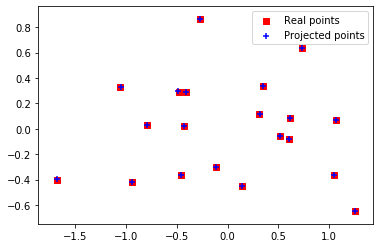

In [6]:
points_2d_proj = project_points(p_m, points_3d)
utils.visualize_points(points_2d, points_2d_proj)

### Camera center (extrinsic parameter)

Let's estimate one particular extrinsic parameter: the camera center in world coordinates. 

$M = (Q|m_4)$

$C = -Q^{-1}m_4$

In [7]:
def calculate_camera_center(M):
    Q = M[:, 0:3]
    m_4 = M[:, 3]    
    C = np.matmul((-1 * np.linalg.inv(Q)), m_4)
    
    return C

In [8]:
cc = calculate_camera_center(p_m)
cc

array([-1.51267725, -2.35168754,  0.28262819])

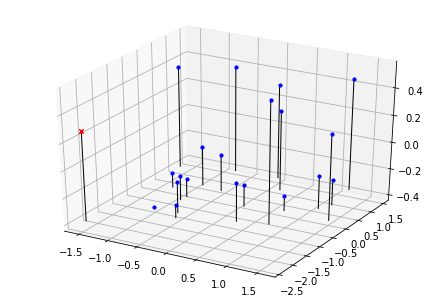

In [9]:
utils.plot3dview(points_3d, cc)

## Fundamental matrix estimation

In [10]:
points_2d_img_a = utils.read_points_2d('data/pts2d-pic_a.txt')
points_2d_img_b = utils.read_points_2d('data/pts2d-pic_b.txt')

In [11]:
def coordinate_normalization(points):
    n = points.shape[0]
    
    # mean coordinates
    c_u, c_v = np.average(points, axis=0)
    
    # scale factor (by standard deviation)
    points_bar = points - np.array([c_u, c_v])
    s_sum = np.sum(points_bar ** 2)
    s = (s_sum / (2 * n)) ** 0.5
    s = 1.0 / s
    
    P = s * points_bar
    
    M_1 = np.array(
        [[s, 0, 0],
         [0, s, 0],
         [0, 0, 1]]
        )
    
    M_2 = np.array(
        [[1, 0, -c_u],
         [0, 1, -c_v],
         [0, 0, 1]]
        )
    
    T = np.matmul(M_1, M_2)
        
    return P, T

In [12]:
def estimate_fundamental_matrix(points_img_a, points_img_b):
    n = points_img_a.shape[0]
    
    # coordinate normalization
    y, T = coordinate_normalization(points_img_a)
    y_, T_ = coordinate_normalization(points_img_b)
        
    # homogeneous linear equation
    y_bar = np.zeros((n, 9))
    
    y_bar[:, 0:2] = y_[:, 0].reshape(n, 1) * y
    y_bar[:, 2] = y_[:, 0]
    y_bar[:, 3:5] = y_[:, 1].reshape(n, 1) * y
    y_bar[:, 5] = y_[:, 1]
    y_bar[:, 6:8] = y
    y_bar[:, 8] = 1.0
    
    U, S, VT = np.linalg.svd(y_bar)
    F = VT[VT.shape[0] - 1, :].reshape(3, 3)
    
    U, S, VT = np.linalg.svd(F)
    
    # set min values of S to 0
    min_S = np.argmin(S)
    S[min_S] = 0
    S = np.diag(S)
    
    F = np.matmul(U, np.matmul(S, VT))
    
    # fundamental matrix
    F = np.matmul(T_.T, np.matmul(F, T))
    
    return F

In [13]:
F = estimate_fundamental_matrix(points_2d_img_a, points_2d_img_b)
F

array([[-1.17248591e-07,  1.60824663e-06, -4.01980786e-04],
       [ 1.11212887e-06, -2.73443755e-07,  3.23319884e-03],
       [-2.36400817e-05, -4.44404958e-03,  1.03455561e-01]])

In [14]:
img_a = utils.load_image('data/pic_a.jpg')
img_b = utils.load_image('data/pic_b.jpg')

### Draw epipolar lines

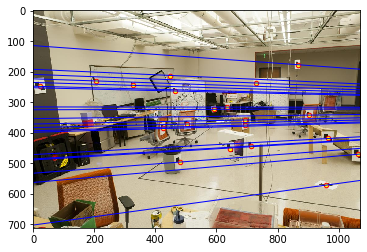

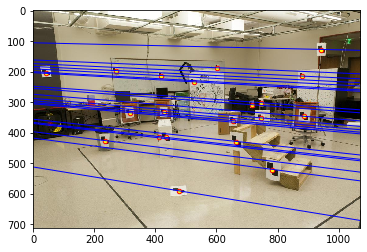

In [16]:
utils.draw_epipolar_lines(F, img_a, img_b, points_2d_img_a, points_2d_img_b)